In [9]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import zscore

In [33]:
# Open the raster file
with rasterio.open('../data/graz/rasters/cnn_result.tif') as src:
    band = src.read(1)  # Read the first band
    profile = src.profile
    transform = src.transform  # Get the affine transform

# Mask invalid values (e.g., nodata)
if src.nodata is not None:
    mask = band == src.nodata  # mask the nodata pixels (True where invalid)
else:
    mask = ~np.isfinite(band)  # fallback: mask non-finite values
valid_data = np.ma.masked_array(band, mask)

In [17]:
valid_data

masked_array(
  data=[[-0.014519843272864819, -0.015225159004330635,
         -0.015225159004330635, ..., 0.0, 0.0, 0.0],
        [-0.015225159004330635, -0.015225159004330635,
         -0.015225159004330635, ..., 0.0, 0.0, 0.0],
        [-0.015225159004330635, -0.015225159004330635,
         -0.015225159004330635, ..., 0.0, 0.0, 0.0],
        ...,
        [0.0, 0.0, 0.0, ..., 0.0, 0.0, 0.0],
        [0.0, 0.0, 0.0, ..., 0.0, 0.0, 0.0],
        [0.0, 0.0, 0.0, ..., 0.0, 0.0, 0.0]],
  mask=[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],
  fill_value=1e+20,
  dtype=float32)

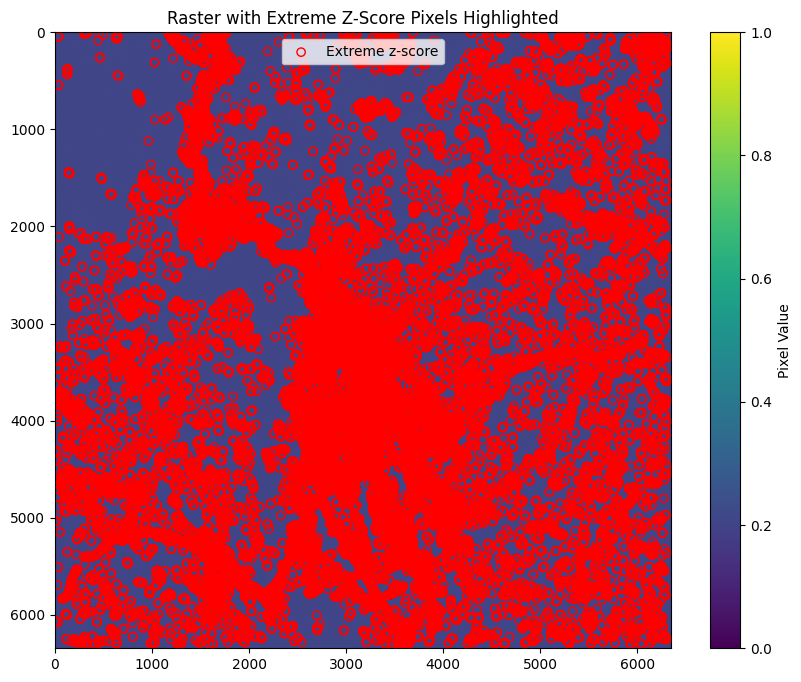

In [18]:
# Compute z-scores
zscores = zscore(valid_data.compressed())  # compress to exclude masked
zscores_full = np.ma.array(np.full(valid_data.shape, np.nan), mask=mask)
zscores_full[~mask] = zscores

# Find extreme values
extreme_mask = (zscores_full < -3) | (zscores_full > 3)

# Get the row, col indices of the extreme values
rows, cols = np.where(extreme_mask)

# Convert to x, y using the affine transform
xs, ys = rasterio.transform.xy(transform, rows, cols)

# Plotting
plt.figure(figsize=(10, 8))
plt.imshow(valid_data, cmap='viridis')
plt.scatter(cols, rows, facecolors='none', edgecolors='red', label='Extreme z-score')
plt.title('Raster with Extreme Z-Score Pixels Highlighted')
plt.legend()
plt.colorbar(label='Pixel Value')
plt.show()

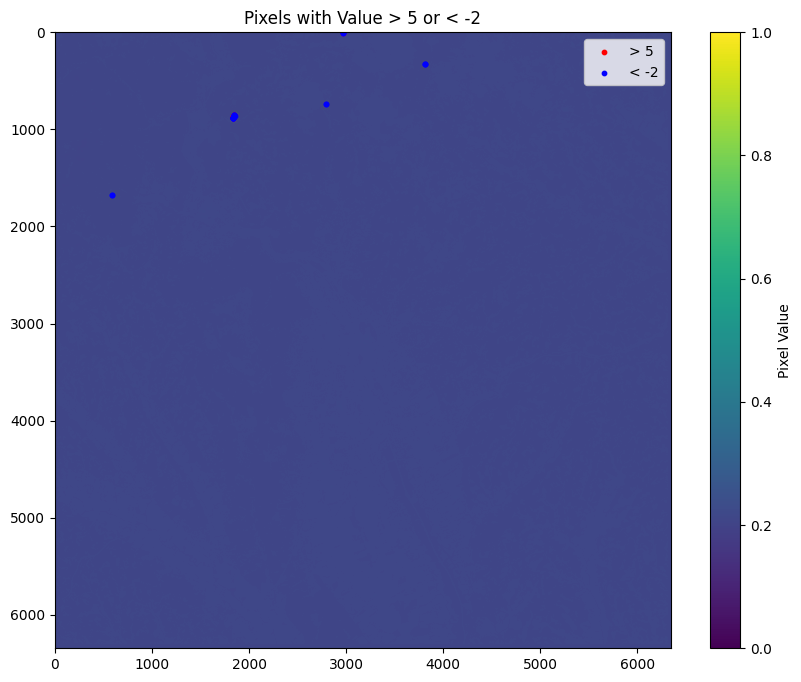

In [21]:
# Conditions
greater_than_5 = (valid_data > 5)
less_than_minus_2 = (valid_data < -2)

# Get pixel coordinates
rows1, cols1 = np.where(greater_than_5)
rows2, cols2 = np.where(less_than_minus_2)

# Plot
plt.figure(figsize=(10, 8))
plt.imshow(valid_data, cmap='viridis', origin='upper')
plt.scatter(cols1, rows1, color='red', label='> 5', s=10)
plt.scatter(cols2, rows2, color='blue', label='< -2', s=10)
plt.title('Pixels with Value > 5 or < -2')
plt.legend()
plt.colorbar(label='Pixel Value')
plt.show()

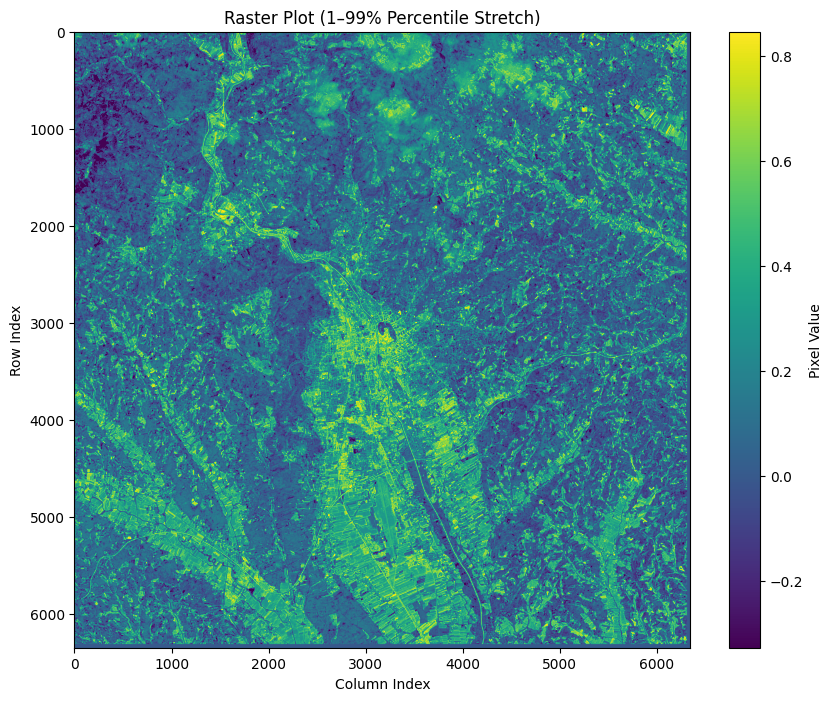

In [27]:
# Mask nodata values (optional but recommended)
if src.nodata is not None:
    mask = band == src.nodata
else:
    mask = ~np.isfinite(band)

masked = np.ma.masked_array(band, mask)

vmin, vmax = np.percentile(masked.compressed(), [1, 99])

plt.figure(figsize=(10, 8))
plt.imshow(masked, cmap='viridis', origin='upper', vmin=vmin, vmax=vmax)
plt.title("Raster Plot (1–99% Percentile Stretch)")
plt.colorbar(label="Pixel Value")
plt.xlabel("Column Index")
plt.ylabel("Row Index")
plt.show()

In [35]:
# Clip and normalize data to 0–255 range for visualization
clipped = np.clip(band, vmin, vmax)

# Update metadata for 8-bit output
#profile.update(dtype=rasterio.uint8, count=1)

# Export
with rasterio.open('../data/graz/rasters/cnn_result_clipped.tif', 'w', **profile) as dst:
    dst.write(clipped, 1)